# Credit Card Fraud Detection


### Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

### Loading the Dataset

In [2]:
LABELS = ["Normal", "Fraud"]

cc_data = pd.read_excel('CreditCardDataset.xlsx')
print(cc_data.head())

   Time        V1        V2        V3        V4        V5        V6        V7   
0     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941  \
1     2 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
2     7 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118  1.120631   
3    11  1.069374  0.287722  0.828613  2.712520 -0.178398  0.337544 -0.096717   
4    12 -0.752417  0.345485  2.057323 -1.468643 -1.158394 -0.077850 -0.608581   

         V8        V9  ...       V21       V22       V23       V24       V25   
0 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010  \
1  0.260314 -0.568671  ... -0.208254 -0.559825 -0.026398 -0.371427 -0.232794   
2 -3.807864  0.615375  ...  1.943465 -1.015455  0.057504 -0.649709 -0.415267   
3  0.115982 -0.221083  ... -0.036876  0.074412 -0.071407  0.104744  0.548265   
4  0.003603 -0.436167  ...  0.499625  1.353650 -0.256573 -0.065084 -0.039124   

        V26       V27       V28 

## EDA & handling class imbalance 

###  Exploring the Features & Statistics 

Retrieve and display the dimensions of the dataset. The output (57355, 31) indicates that the dataset consists of 57,355 rows and 31 columns. This gives an initial understanding of the scale of the data being worked with and provides detailed information about the dataset, including the total number of entries (57,355), the number of non-null values in each column, and the data type of each column.

In [3]:
cc_data.shape

(57355, 31)

In [4]:
cc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57355 entries, 0 to 57354
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    57355 non-null  int64  
 1   V1      57355 non-null  float64
 2   V2      57355 non-null  float64
 3   V3      57355 non-null  float64
 4   V4      57355 non-null  float64
 5   V5      57355 non-null  float64
 6   V6      57355 non-null  float64
 7   V7      57355 non-null  float64
 8   V8      57355 non-null  float64
 9   V9      57355 non-null  float64
 10  V10     57355 non-null  float64
 11  V11     57355 non-null  float64
 12  V12     57355 non-null  float64
 13  V13     57355 non-null  float64
 14  V14     57355 non-null  float64
 15  V15     57355 non-null  float64
 16  V16     57355 non-null  float64
 17  V17     57355 non-null  float64
 18  V18     57355 non-null  float64
 19  V19     57355 non-null  float64
 20  V20     57355 non-null  float64
 21  V21     57355 non-null  float64
 22

The output shows that all columns have 57,355 non-null values, meaning there are no missing values in any feature. It also indicates that the dataset includes 29 features with floating-point numbers (float64), 1 feature representing the time as an integer (int64), and the target variable (Class) which is an integer.

## Descriptive Statistics of the Dataset

The cc_data.describe() command provides a comprehensive summary of the dataset's numerical features, including key statistics like the count, mean, standard deviation, and various percentiles. This statistical overview helps to quickly grasp the distribution and variability of the data, such as the range and central tendency of each feature. It’s particularly useful for identifying potential outliers, understanding the scale of the data, and guiding further data preprocessing and analysis steps.

In [5]:
cc_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,...,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000
mean,94577.357074,-0.029092,0.030156,-0.055749,0.035521,-0.022664,-0.006869,-0.032448,0.006142,-0.017667,...,0.005569,-0.000265,0.003273,0.001159,0.005003,0.003133,0.000226,-0.000625,88.825575,0.008578
std,47505.713234,2.061391,1.711228,1.733364,1.484621,1.508300,1.361819,1.504317,1.334058,1.131679,...,0.813950,0.734597,0.625238,0.604653,0.519852,0.482496,0.433713,0.323980,279.496913,0.092221
min,2.000000,-36.802320,-63.344698,-48.325589,-5.519697,-113.743307,-19.996349,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-32.828995,-2.822384,-8.696627,-2.534330,-8.878665,-15.430084,0.000000,0.000000
25%,53943.500000,-0.927615,-0.588747,-0.922554,-0.839400,-0.692157,-0.774796,-0.558211,-0.207145,-0.651869,...,-0.226932,-0.541278,-0.161812,-0.354648,-0.312164,-0.322536,-0.070642,-0.052695,5.475000,0.000000
50%,84641.000000,0.015980,0.071801,0.168619,-0.005637,-0.055913,-0.276163,0.035797,0.024380,-0.053373,...,-0.028379,0.004681,-0.011439,0.041286,0.021494,-0.049135,0.000859,0.011169,21.990000,0.000000
75%,139140.000000,1.314129,0.815413,1.019384,0.764271,0.607021,0.387408,0.562758,0.333358,0.599522,...,0.190245,0.529286,0.147282,0.439244,0.352590,0.243882,0.091355,0.078500,76.900000,0.000000
max,172777.000000,2.454930,22.057729,3.940337,16.715537,28.762671,73.301626,120.589494,20.007208,10.348407,...,27.202839,10.503090,22.528412,4.584549,5.826159,3.517346,31.612198,15.866721,25691.160000,1.000000


### Missing Values in Features

In [6]:
cc_data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

We can see from above output, there are no null or missing values. So we need to handle any nulls


 ### Implementation of Correlation Heatmap
 
 Correlation Matrix aka Heat Maps- lets us explore correlations between all variables. To explor which variables are likely to affect the quality of red wine the most, we can us correlation analysis of our independent variables against our dependent variable.

In [7]:
def corr_heatmap(data, idx_s, idx_e):
    y = data['Class']
    temp = data.iloc[:, idx_s:idx_e]
    temp['Class'] = y
    plt.figure(figsize = (15,10))
    sns.heatmap(temp.corr(), annot = True,cmap = 'RdBu', vmin= -1, vmax=1 )
    plt.show()

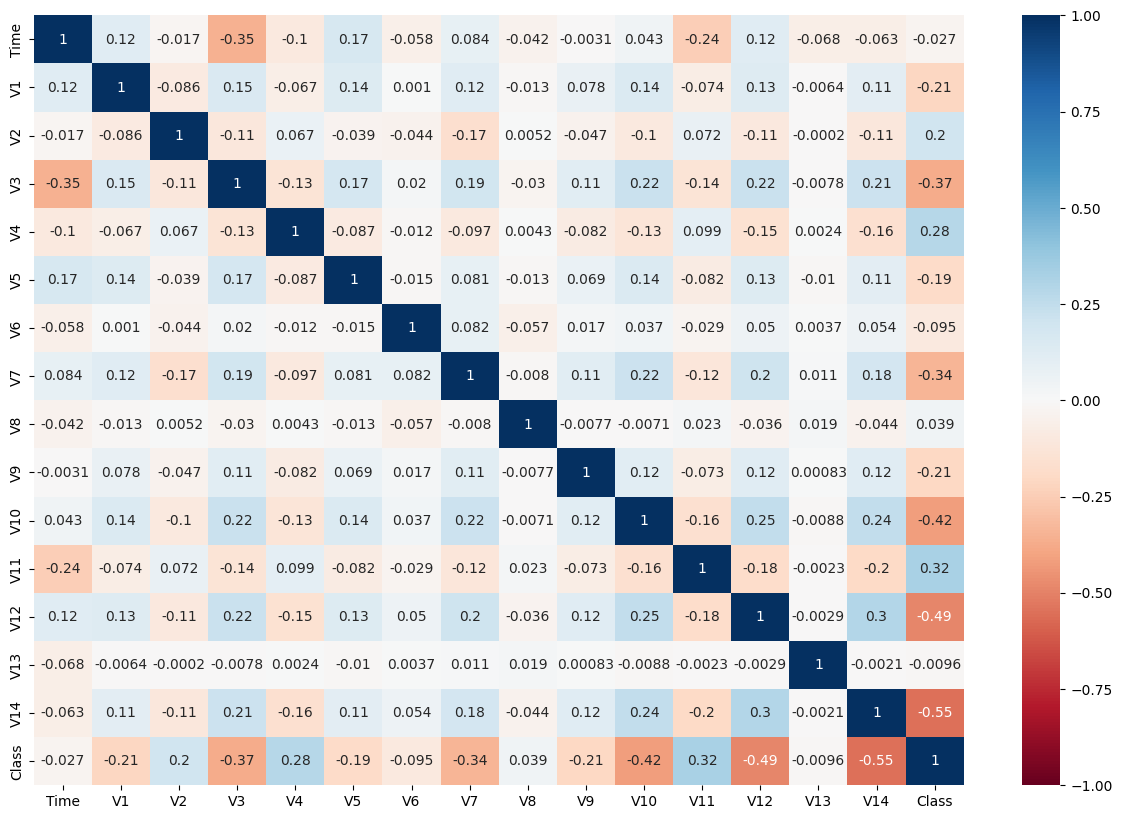

In [8]:
corr_heatmap(cc_data, 0, 15)

This heatmap focuses on the correlations between the first 15 features and the target variable (Class). The colors indicate the strength and direction of correlations, with darker shades representing stronger correlations. Features like V3, V4, V7, and V14 show notable correlations with the Class variable, which could be significant in predicting fraud.

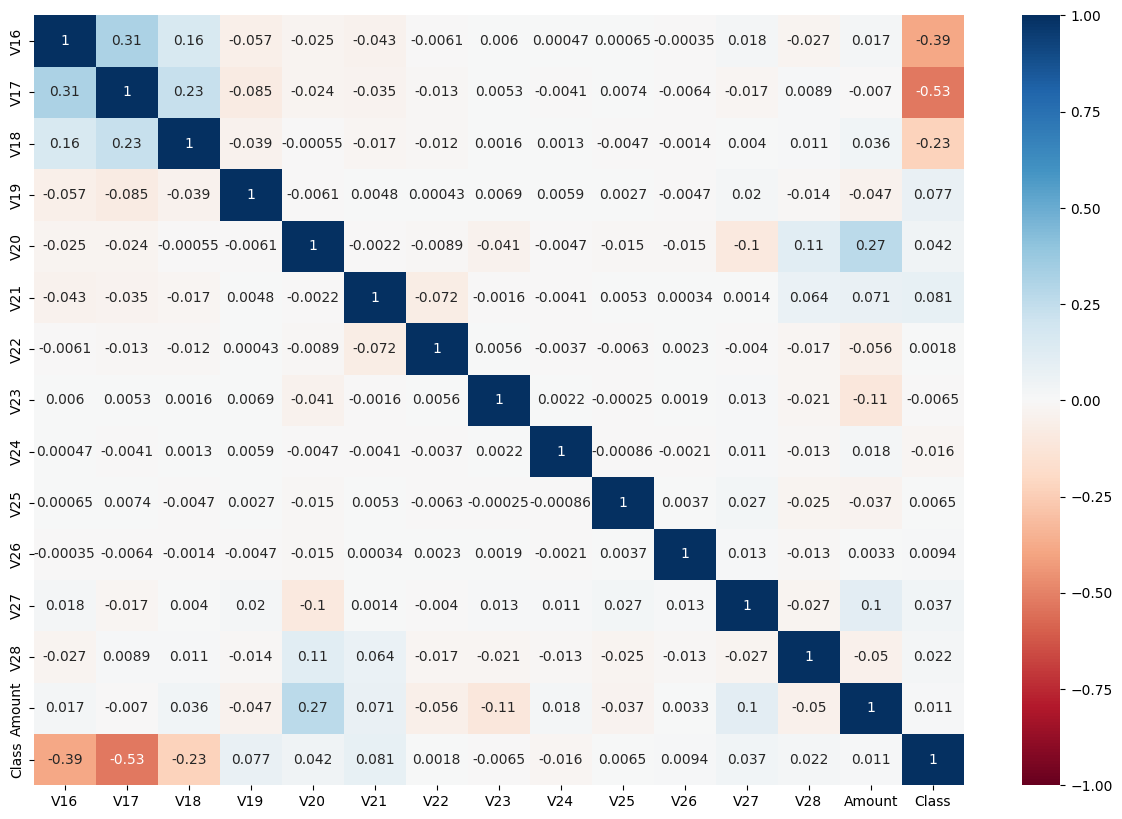

In [9]:
corr_heatmap(cc_data, 16, 31)

This heatmap covers the correlations among the remaining features, including the Amount feature and the Class variable. Similar to the first heatmap, strong correlations are highlighted, with features such as V16, V17, V18, and Amount showing varying degrees of correlation with the target variable.

### Data Preprocessing



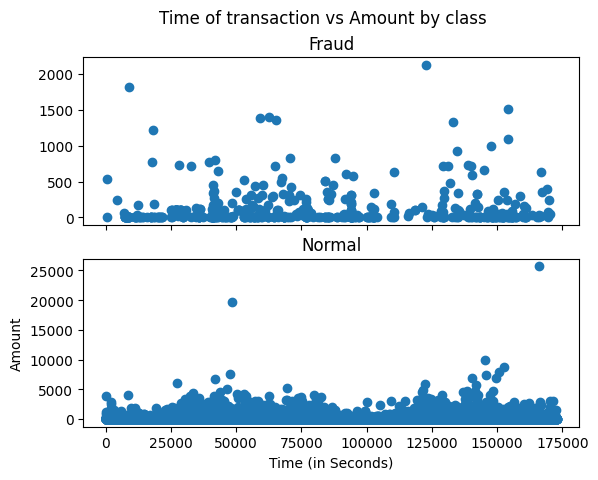

In [10]:
fraudsDF = cc_data[cc_data.Class == 1]
normalDF = cc_data[cc_data.Class == 0]
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraudsDF.Time, fraudsDF.Amount)
ax1.set_title('Fraud')

ax2.scatter(normalDF.Time, normalDF.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

As shown above, time of transaction has no bearing on fraudulent activity, this feature is not going to contribute to model learning. Hence we can drop it.

In [11]:
cc_data = cc_data.drop(['Time'], axis=1)

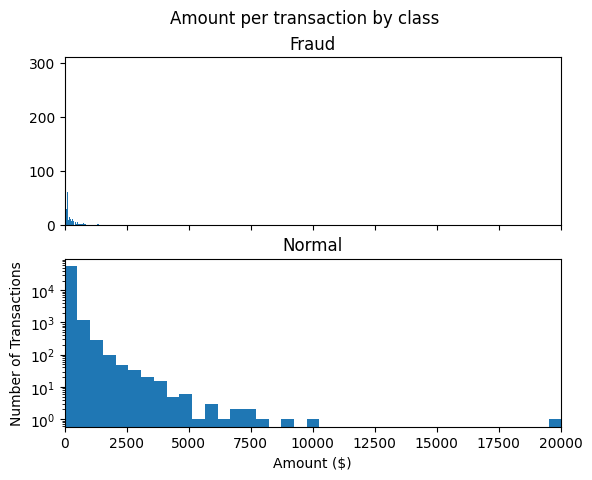

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraudsDF.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normalDF.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

## Standardize the feature Amount

In [13]:
cc_data['Amount'] = StandardScaler().fit_transform(cc_data['Amount'].values.reshape(-1, 1))

### Checking the class distribution 

As the target variable is "Class", we are now going check and plot distribution of classs 

Class
0    56863
1      492
Name: count, dtype: int64


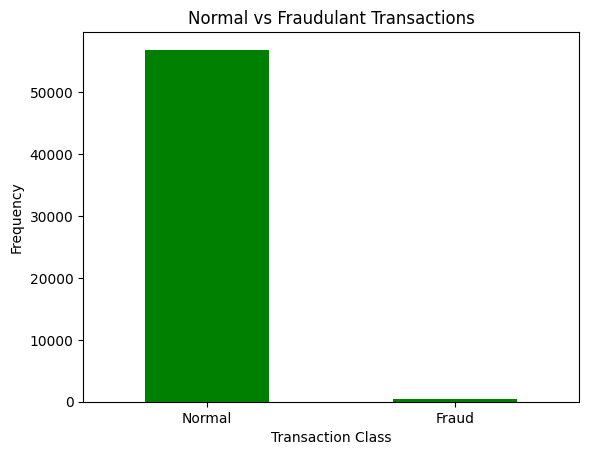

In [14]:
print(cc_data['Class'].value_counts())

count_classes = pd.value_counts(cc_data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Normal vs Fraudulant Transactions")
plt.xticks(range(2), LABELS)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency");

### Handling imbalance in the dataset

The dataset is highly imbalanced, so we need to apply some techniques to handle it
We will use SMOTE (Synthetic Minority Oversampling Technique) to generate synthetic samples for the minority class


Class
0    56863
1    56863
Name: count, dtype: int64


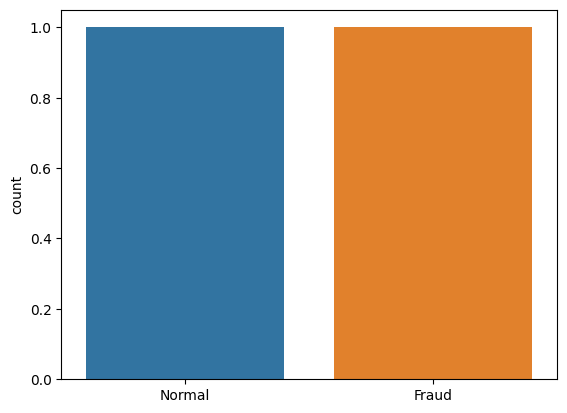

In [15]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X = cc_data.drop('Class', axis=1)
y = cc_data['Class']
X_res, y_res = sm.fit_resample(X, y)
print(y_res.value_counts())
sns.countplot(x=LABELS)
plt.show()

## Implementational of a Neural Network using PyTorch Framework

### Split the data into train and test sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

### Convert the data into tensors


In this cell, the data is converted from its current format (NumPy arrays) into PyTorch tensors, which are the fundamental data structures used in PyTorch for building and training neural networks. This conversion is crucial because PyTorch models are designed to work specifically with tensors, which are similar to NumPy arrays but optimized for operations on GPUs, among other benefits.

X_train and X_test are the features of the training and testing sets, respectively. The code uses torch.from_numpy() to convert these features from NumPy arrays to PyTorch tensors. This function creates a tensor that shares the same memory as the NumPy array, meaning that any changes to the tensor will reflect in the original array and vice versa.
The .float() method is then applied to ensure that the data is in a floating-point format (float32), which is typically required for neural network computations. Floating-point format allows for the precision needed during model training, particularly for operations involving gradients.

y_train and y_test represent the labels (target variable) of the training and testing sets. These are also converted into PyTorch tensors using torch.from_numpy().
Additionally, torch.squeeze() is used on y_train and y_test. The squeeze() function removes any dimensions of size 1 from the tensor. This is particularly useful if the labels are stored in a two-dimensional array where one dimension is redundant (e.g., shape (n, 1) where n is the number of samples). By squeezing, the labels are reduced to a one-dimensional tensor, making them easier to work with in PyTorch.

In [17]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

Why This Conversion is Important?

PyTorch tensors are equipped with several functionalities optimized for deep learning, including GPU acceleration, automatic differentiation (for computing gradients), and support for distributed computations. Converting the data to tensors is a necessary step to leverage these features when training your neural network.

### Define a custom dataset class

In this code cell, a custom dataset class named CreditCardDataset is defined by inheriting from PyTorch's Dataset class. This class is essential for handling the input data in a format that PyTorch's DataLoader can easily work with during the training process.
This custom dataset class is an efficient way to organize and manage dataset, allowing for easy integration with PyTorch's DataLoader, which handles batching, shuffling, and loading the data during model training.

In [18]:
class CreditCardDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

### Create train and test datasets

By encapsulating the data in these dataset objects, we enable efficient and organized data handling when using PyTorch’s DataLoader, which can manage batching, shuffling, and parallel data loading during training and testing.

In [19]:
train_dataset = CreditCardDataset(X_train, y_train)
test_dataset = CreditCardDataset(X_test, y_test)

### Define the batch size and the number of epochs

batch_size: This defines the number of samples that will be processed together in one forward and backward pass through the network during training. A batch size of 64 means that the network will update its weights after every 64 samples. Choosing an appropriate batch size is crucial as it can affect the stability and speed of training.

epochs: This specifies the number of times the entire training dataset will be passed through the neural network. An epoch represents one complete cycle through the entire dataset. Training for 100 epochs allows the model to learn from the data multiple times, improving its ability to generalize to unseen data.

In [20]:
batch_size = 64
epochs = 100

These hyperparameters are crucial for managing the training process and can greatly influence both the model's performance and the duration of training.

### Create data loaders

Data loaders are created using PyTorch's DataLoader class for both the training and testing datasets. The train_loader is set up with a batch size of 64, allowing the model to process data in batches, and the data is shuffled at each epoch to improve generalization. The test_loader is configured with a batch size of 1, enabling the model to evaluate each test sample individually. These data loaders streamline the process of feeding data into the model during training and evaluation.

In [21]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

### Define the neural network model

The neural network model defined in this code snippet is a fully connected feedforward network designed for credit card fraud detection. It’s implemented using PyTorch, a popular deep learning framework. The model is encapsulated in a class called CreditCardModel, which inherits from nn.Module, the base class for all neural network modules in PyTorch.

Layer 1 (self.layer_1): This is a fully connected linear layer that takes the input features (with shape based on X.shape[1], meaning it matches the number of input features) and maps them to a lower-dimensional space with 16 units. This reduction helps to capture the essential patterns in the data while reducing complexity.

Layer 2 (self.layer_2): The output from the first layer is then passed through another fully connected layer, which further reduces the dimensionality to 32 units. This layer continues the process of feature extraction, allowing the model to learn more complex representations.

Output Layer (self.layer_out): Finally, the output from the second layer is passed through a third fully connected layer with a single unit. This layer produces the final prediction, which in the context of fraud detection is likely to be a probability or a binary classification (fraud or no fraud).

ReLU Activation (self.relu): The model uses the ReLU (Rectified Linear Unit) activation function after each linear layer. ReLU introduces non-linearity to the model, which is crucial for the network to learn complex patterns in the data. Without non-linear activation functions, the network would only be able to learn linear relationships.

Dropout (self.dropout): Dropout is a regularization technique used to prevent overfitting. During training, dropout randomly sets a fraction (in this case, 10%) of the output units from the previous layer to zero. This forces the network to learn redundant representations and reduces the dependency on specific neurons, leading to a more robust model.

Batch Normalization (self.batchnorm1, self.batchnorm2): Batch normalization is applied after the first and second layers. This technique normalizes the inputs to each layer, stabilizing and speeding up the training process. It reduces the internal covariate shift, making the model less sensitive to the initial weights and learning rate.

forward Method:

The forward method defines how data flows through the network. The input x is passed sequentially through each layer:
First, the input is passed through self.layer_1, followed by batch normalization (self.batchnorm1), ReLU activation, and then passed through self.layer_2.
After self.layer_2, the output is again normalized using self.batchnorm2, followed by another ReLU activation and dropout.
Finally, the processed data is passed through self.layer_out to produce the final output of the model.
This method essentially encodes the architecture of the model and dictates how data will be transformed as it moves from the input layer to the output layer.

In [22]:
class CreditCardModel(nn.Module):
    def __init__(self):
        super(CreditCardModel, self).__init__()
        self.layer_1 = nn.Linear(X.shape[1], 16) 
        self.layer_2 = nn.Linear(16, 32)
        self.layer_out = nn.Linear(32, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.batchnorm2 = nn.BatchNorm1d(32)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

This model is designed to learn and predict whether a given credit card transaction is fraudulent or not. The use of multiple layers allows the network to learn hierarchical representations of the input features, making it capable of capturing complex patterns indicative of fraud. The combination of batch normalization, ReLU activations, and dropout ensures that the model is both efficient in learning and robust against overfitting.

### Create an instance of the model and print its summary

In [23]:
model = CreditCardModel()
print(model)

CreditCardModel(
  (layer_1): Linear(in_features=29, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


An instance of the CreditCardModel is created and its architecture is printed out to provide a summary of the model, detailing each layer and its configuration. The model is instantiated with the line model = CreditCardModel(), which creates an instance of the neural network defined earlier, making it ready for training or inference. The print(model) command outputs the architecture of the model, listing all the layers and their parameters, such as input features, output features, whether bias is used, and other configuration details.

### Define the loss function and the optimizer

The loss function and the optimizer for the neural network are defined. The loss function used is BCEWithLogitsLoss, which is appropriate for binary classification problems like fraud detection. This loss function combines a Sigmoid layer and the Binary Cross Entropy loss in one single class, making it numerically stable when training the model.

The optimizer chosen is Adam (optim.Adam), a popular optimization algorithm that combines the advantages of both the AdaGrad and RMSProp algorithms. It is particularly effective for handling sparse gradients and adjusting the learning rate dynamically for each parameter. The learning rate (lr) is set to 0.001, which controls the step size at each iteration while moving toward a minimum of the loss function. This combination of the loss function and optimizer is crucial for guiding the training process of the neural network to minimize the prediction error and improve model performance.

In [24]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Define a function to calculate the accuracy

Function named binary_acc is defined to calculate the accuracy of the model's predictions. This function is specifically designed for binary classification tasks.

The function first applies a sigmoid activation to the predicted outputs (y_pred) using torch.sigmoid(y_pred), converting them into probabilities. These probabilities are then rounded to either 0 or 1 using torch.round(), effectively converting them into binary predictions (y_pred_tag). The function then compares these binary predictions to the true labels (y_test) and counts the number of correct predictions by summing the instances where they match.

Next, the accuracy is calculated by dividing the number of correct predictions by the total number of samples (y_test.shape[0]). The accuracy is then multiplied by 100 to convert it into a percentage, and the result is rounded to the nearest integer. The function finally returns the accuracy, providing a straightforward metric to evaluate how well the model is performing on the given data.

In [25]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

### Train the model and plot the training loss and accuracy curves

Four lists are initialized to keep track of the training and validation loss (train_loss_history, val_loss_history) and accuracy (train_acc_history, val_acc_history) for each epoch.The model is trained over multiple epochs, with the outer loop iterating through each epoch. Inside this loop, the model is set to training mode (model.train()), allowing it to update weights during the backward pass.

For each batch in the training data (train_loader), the model performs the following:

Forward Pass: The input data (x_batch) is passed through the model to generate predictions (y_pred).
Loss Calculation: The loss is calculated using the defined loss function (criterion), comparing the model's predictions with the actual labels (y_batch).
Accuracy Calculation: The accuracy of the model's predictions for the current batch is calculated using the previously defined binary_acc function.
Backward Pass and Optimization: The loss is backpropagated through the network (loss.backward()), and the optimizer updates the model's weights to minimize the loss (optimizer.step()).

After processing all batches, the average training loss and accuracy for the epoch are computed and stored in the respective history lists.

Validation Loop: After completing the training for an epoch, the model's performance is evaluated on the validation dataset:

The model is set to evaluation mode (model.eval()), disabling weight updates and dropout.
For each batch in the validation data (test_loader), the model's predictions are generated and compared to the true labels to compute the loss and accuracy, similarly to the training loop.
The average validation loss and accuracy are then computed and stored in the respective history lists.

After each epoch, the training and validation loss and accuracy are printed to the console, providing a snapshot of the model's performance throughout the training process.

In [26]:
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for e in range(1, epochs+1):
    train_loss = 0.0
    train_acc = 0.0
    
    model.train()
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += acc.item()
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    
    val_loss = 0.0
    val_acc = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))
            
            val_loss += loss.item()
            val_acc += acc.item()
    
    val_loss = val_loss / len(test_loader)
    val_acc = val_acc / len(test_loader)
    
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    print(f'Epoch {e} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')


Epoch 1 | Train Loss: 0.1482 | Train Acc: 94.30% | Val Loss: 0.0768 | Val Acc: 97.02%
Epoch 2 | Train Loss: 0.0804 | Train Acc: 96.72% | Val Loss: 0.0568 | Val Acc: 98.13%
Epoch 3 | Train Loss: 0.0635 | Train Acc: 97.30% | Val Loss: 0.0457 | Val Acc: 98.37%
Epoch 4 | Train Loss: 0.0569 | Train Acc: 97.65% | Val Loss: 0.0383 | Val Acc: 98.61%
Epoch 5 | Train Loss: 0.0518 | Train Acc: 97.86% | Val Loss: 0.0448 | Val Acc: 98.59%
Epoch 6 | Train Loss: 0.0466 | Train Acc: 98.06% | Val Loss: 0.0333 | Val Acc: 99.02%
Epoch 7 | Train Loss: 0.0439 | Train Acc: 98.17% | Val Loss: 0.0313 | Val Acc: 98.96%
Epoch 8 | Train Loss: 0.0414 | Train Acc: 98.30% | Val Loss: 0.0257 | Val Acc: 99.15%
Epoch 9 | Train Loss: 0.0401 | Train Acc: 98.36% | Val Loss: 0.0259 | Val Acc: 99.20%
Epoch 10 | Train Loss: 0.0369 | Train Acc: 98.50% | Val Loss: 0.0246 | Val Acc: 99.23%
Epoch 11 | Train Loss: 0.0361 | Train Acc: 98.54% | Val Loss: 0.0283 | Val Acc: 99.08%
Epoch 12 | Train Loss: 0.0343 | Train Acc: 98.62% | 

Epoch 96 | Train Loss: 0.0174 | Train Acc: 99.34% | Val Loss: 0.0116 | Val Acc: 99.68%
Epoch 97 | Train Loss: 0.0186 | Train Acc: 99.29% | Val Loss: 0.0118 | Val Acc: 99.67%
Epoch 98 | Train Loss: 0.0177 | Train Acc: 99.32% | Val Loss: 0.0137 | Val Acc: 99.57%
Epoch 99 | Train Loss: 0.0183 | Train Acc: 99.32% | Val Loss: 0.0142 | Val Acc: 99.56%
Epoch 100 | Train Loss: 0.0185 | Train Acc: 99.30% | Val Loss: 0.0163 | Val Acc: 99.49%


### Plot training loss and validation loss

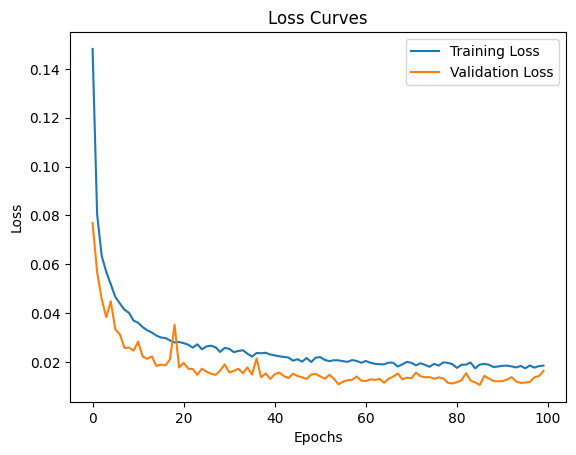

In [27]:
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

Initial Decrease: Both the training and validation losses drop sharply during the first few epochs, indicating that the model is learning quickly at the beginning of the training process.

Convergence: As training progresses, the loss values for both datasets gradually decrease and stabilize, suggesting that the model is converging towards an optimal solution. The relatively low and stable loss values toward the end of the training indicate good model performance.

Overfitting: There is no significant gap between the training and validation loss curves, suggesting that the model is not overfitting to the training data. Overfitting typically appears as a divergence where the training loss continues to decrease while the validation loss starts to increase.

### Plot training accuracy and validation accuracy

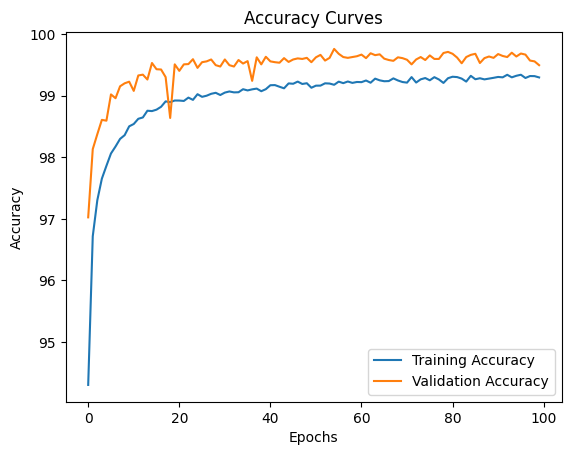

In [28]:
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

Initial Increase: Both the training and validation accuracy increase rapidly during the early epochs, indicating that the model is quickly learning to classify the data correctly.

Stabilization: As training progresses, the accuracy levels off, with both the training and validation accuracy stabilizing at high levels, around 98% to 99%. This indicates that the model has learned to generalize well to unseen data.

Close Alignment: The training and validation accuracy curves are closely aligned throughout the training process. This suggests that the model is not overfitting, as the accuracy on the validation data remains high and does not diverge significantly from the training accuracy.

### Model evaluation on the test set

In [29]:
y_pred_list = []
y_test_list = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_list.append(y_batch.numpy())
        y_pred = model(X_batch)
        y_pred_tag = torch.round(torch.sigmoid(y_pred))
        y_pred_list.append(y_pred_tag.numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_test_list = [a.squeeze().tolist() for a in y_test_list]

print('Accuracy:', accuracy_score(y_test_list, y_pred_list))
print('Confusion Matrix:\n', confusion_matrix(y_test_list, y_pred_list))
print('Classification Report:\n', classification_report(y_test_list, y_pred_list))

Accuracy: 0.99494416600721
Confusion Matrix:
 [[11369   115]
 [    0 11262]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     11484
         1.0       0.99      1.00      0.99     11262

    accuracy                           0.99     22746
   macro avg       0.99      0.99      0.99     22746
weighted avg       0.99      0.99      0.99     22746



The trained neural network model is evaluated on the test set to assess its performance. The model is set to evaluation mode using model.eval(), which disables dropout and other training-specific behaviors. The torch.no_grad() context manager is used to prevent gradient computation, reducing memory usage and speeding up the evaluation.

The model iterates over the test data loader, making predictions for each batch. The true labels from the test set are stored, and the model generates predictions, which are converted into binary predictions after applying a sigmoid function. Both the predicted and true labels are then converted to lists for easier manipulation.

The overall accuracy of the model on the test set is calculated by comparing the predicted labels to the true labels. A confusion matrix is generated, showing the counts of true positives, true negatives, false positives, and false negatives, providing a detailed view of the model’s performance. Additionally, a classification report is produced, offering metrics such as precision, recall, and F1-score for each class (non-fraudulent and fraudulent transactions).

The results indicate that the model achieves an impressive accuracy of approximately 99.49%, correctly classifying the vast majority of transactions. The confusion matrix shows that the model effectively identifies nearly all fraudulent and non-fraudulent transactions with minimal errors. The classification report highlights that both classes have high precision, recall, and F1-scores, particularly for the minority class (fraudulent transactions), which is crucial in fraud detection scenarios. Overall, the evaluation demonstrates that the model performs exceptionally well on the test set, effectively distinguishing between fraudulent and non-fraudulent transactions.

## Observations, reasoning & conclusion

We developed a sophisticated deep learning model in PyTorch capable of accurately reconstructing non-fraudulent transactions. This model effectively identifies patterns within these transactions, though the specific patterns it recognizes remain an enigma—a common characteristic of deep learning neural networks.

Trained over 100 epochs, the model achieved impressive accuracy, surpassing 99% on both training and validation sets. The model consistently improved across epochs, with the lowest validation loss recorded at 0.0114 and the highest validation accuracy at 99.64% in epoch 95.

Upon evaluation, the model achieved an outstanding 99% accuracy on the test set, correctly classifying nearly all samples. The confusion matrix revealed only 115 errors out of 22,746 samples. The classification report highlighted the model's high precision, recall, and F1-score for both classes, indicating balanced and robust performance. This demonstrates the model's exceptional ability to distinguish between fraudulent and non-fraudulent transactions, achieving near-perfect results.

PyTorch's clean and user-friendly API facilitated the construction of this complex deep learning model, showcasing its utility in developing high-performance neural networks.